In [69]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
import os, glob
from collections import deque
import pylab
import imageio
from collections import deque

filename = 'test_videos/Night.mp4'
reader = imageio.get_reader(filename,  'ffmpeg')
image = reader.get_data(50)

In [153]:
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([100, 100, 100])
    upper = np.uint8([255, 255, 255])
    mask = cv2.inRange(image, lower, upper)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def apply_smoothing(image, kernel_size=1):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def detect_edges(image, low_threshold=30, high_threshold=100):
    return cv2.Canny(image, low_threshold, high_threshold)

def filter_region(image, vertices):
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)       
    return cv2.bitwise_and(image, mask)

def select_region(image):
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, 600]
    top_left     = [cols*0.4, rows*0.7]
    bottom_right = [1000, 600]
    top_right    = [620, 500] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

def hough_lines(image):
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=40, minLineLength=20, maxLineGap=300)

def draw_lines(image, lines, color=[255, 0, 0], thickness=5, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    line_image = np.zeros_like(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

def process(image):
    white_yellow_images = select_rgb_white_yellow(image)
    gray_images = convert_gray_scale(white_yellow_images)
    blurred_images = apply_smoothing(gray_images)
    edge_images = detect_edges(blurred_images)
    roi_images = select_region(edge_images)
    list_of_lines = hough_lines(roi_images)
    lane_images = draw_lines(image, list_of_lines)
    
    return lane_images

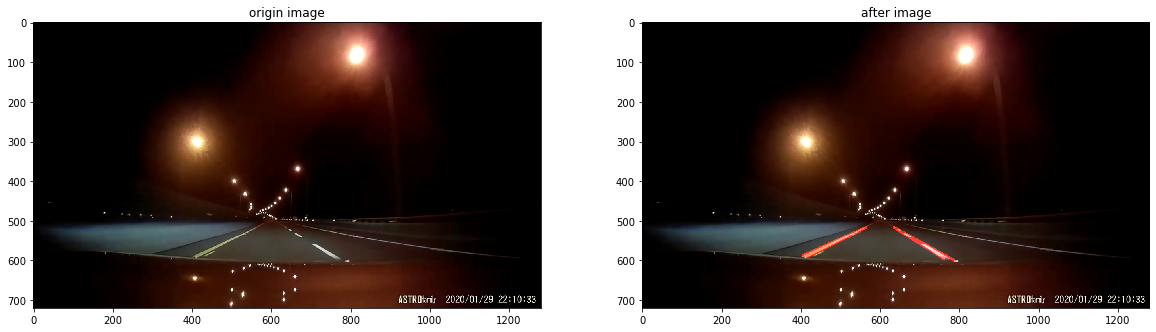

In [154]:
plt.figure(num='astronaut',figsize=(20,20))
plt.subplot(1,2,1)     #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('origin image')   #第一幅图片标题
plt.imshow(image) 

white_yellow_images = select_rgb_white_yellow(image)
gray_images = convert_gray_scale(white_yellow_images)
blurred_images = apply_smoothing(gray_images)
edge_images = detect_edges(blurred_images)
roi_images = select_region(edge_images)
list_of_lines = hough_lines(roi_images)
lane_images = draw_lines(image, list_of_lines)

plt.subplot(1,2,2)     #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('after image')   #第一幅图片标题
plt.imshow(lane_images) 
plt.show()


In [155]:
filename = 'test_videos/Night.mp4'
reader = imageio.get_reader(filename,  'ffmpeg')
fps = reader.get_meta_data()['fps']
writer = imageio.get_writer('test_videos_output/Night_output.mp4', fps=fps)
for im in reader:
    writer.append_data(process(im))
writer.close()